In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Code

In [ ]:
import logging

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


plt.style.use("ggplot")

np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import re

# Get all CSVs to DFs
base_folder = "/content/drive/MyDrive/472 Project Files/Classifications/"
files = os.listdir(base_folder)
print(files)

['BioBertClassified.csv', 'DistilledRoBERTaClassified.csv', 'ElectraClassified.csv', 'MedElectraClassified.csv', 'RoBERTaClassified.csv', 'ensemble_eval.csv']


In [ ]:
pd.read_csv("/content/drive/MyDrive/472 Project Files/Classifications/BioBertClassified.csv")

,Unnamed: 0.1,Unnamed: 0,text,label,raw_outputs,predictions
0,0,42240,"Next, ________ tube was used to obtain Gram st...",38,[-1.72460938 -2.8515625 -2.37890625 -0.749023...,38
1,1,143961,The child was continued on IV fluid and narcot...,10,[-0.08898926 -3.79296875 -1.78808594 2.535156...,29
2,2,17010,"GROSS FINDINGS: ,This 53-year-old Caucasian f...",38,[-2.02734375 -3.04882812 -1.69335938 -0.369628...,38
3,3,105375,The rest showed full strength,22,[-3.13476562 -3.24023438 -3.3671875 0.432373...,22
4,4,76401,She denies any pain elsewhere,27,[-1.34179688 -3.79296875 -1.35449219 1.021484...,5
...,...,...,...,...,...,...
38850,38850,100581,"EXAM: ,BP150/79, HR77, RR22, 37.4C",22,[-3.48828125 -2.72070312 -3.70703125 1.374023...,22
38851,38851,79345,"However, it is our contention that this patien...",27,[-2.86132812 -2.875 -2.00976562 -1.159179...,5
38852,38852,36735,The patient had previous diagnosis of carpal t...,38,[-4.37109375 -4.31640625 -3.6015625 0.418212...,27
38853,38853,61286,"They do play well together; however, The patie...",32,[-2.09570312 -3.67578125 -1.62695312 -0.069580...,5


In [ ]:
dfs = None
model_names = []
for file in files:
  m = re.match(r"(\w+)Classified.csv", file)
  if m:
    model_name = m.group(1)
    model_names.append(model_name)
    df = pd.read_csv(base_folder + file)
    if dfs is None:
        dfs = pd.DataFrame(index=df.index)
        dfs["label"] = df["label"]
    dfs[model_name] = df["raw_outputs"]

In [ ]:
dfs

,label,BioBert,DistilledRoBERTa,Electra,MedElectra,RoBERTa
0,38,[-1.72460938 -2.8515625 -2.37890625 -0.749023...,[-2.72656250e+00 -1.82031250e+00 -2.08203125e+...,[-5.72265625 -4.46875 -4.8828125 1.160156...,[ -6.9765625 -7.671875 -6.79296875 -0.80...,[-3.02539062 -2.18554688 -2.609375 0.809082...
1,10,[-0.08898926 -3.79296875 -1.78808594 2.535156...,[-0.1204834 -2.375 -1.84863281 1.983398...,[-3.43359375 -2.66210938 -2.8984375 1.210937...,[-3.06054688 -3.07617188 -2.23632812 1.362304...,[ 0.4921875 -2.73242188 -1.40917969 1.955078...
2,38,[-2.02734375 -3.04882812 -1.69335938 -0.369628...,[-2.5625 -1.328125 -2.02148438 1.321289...,[-5.7109375 -3.74804688 -4.79296875 1.633789...,[-3.91601562 -5.65625 -4.24609375 -1.490234...,[-2.40234375 -2.15820312 -1.55273438 1.365234...
3,22,[-3.13476562 -3.24023438 -3.3671875 0.432373...,[-2.37109375 -2.84765625 -2.80859375 0.539550...,[-4.2265625 -1.11230469 -4.68359375 1.063476...,[-6.26171875e+00 -2.35937500e+00 -6.79296875e+...,[-3.41796875 -3.69921875 -3.2421875 1.035156...
4,27,[-1.34179688 -3.79296875 -1.35449219 1.021484...,[-1.421875 -3.71289062 -1.19824219 0.746582...,[-1.70117188 -3.32421875 -1.82324219 1.034179...,[-2.98046875 -3.34179688 -2.82226562 -0.085693...,[-1.16796875 -3.02929688 -1.00195312 0.828125...
...,...,...,...,...,...,...
38850,22,[-3.48828125 -2.72070312 -3.70703125 1.374023...,[-4.15625000e+00 -2.38671875e+00 -4.26562500e+...,[-5.56640625 -0.46484375 -5.88671875 0.855957...,[ -8.8515625 -2.2890625 -9.3125 -0.30...,[-4.33984375 -2.55859375 -3.8046875 0.859375...
38851,27,[-2.86132812 -2.875 -2.00976562 -1.159179...,[-2.49023438 -3.36328125 -2.26953125 -0.727050...,[-3.140625 -0.71386719 -3.36132812 -0.578613...,[-5.68359375 -3.6484375 -5.421875 -2.330078...,[-3.2578125 -2.67578125 -2.421875 -0.679687...
38852,38,[-4.37109375 -4.31640625 -3.6015625 0.418212...,[-4.48828125 -3.6796875 -3.32421875 -0.030838...,[-5.88671875 -2.22460938 -5.140625 0.398193...,[-10.140625 -6.546875 -8.875 -0.78...,[-3.79101562 -2.74414062 -2.5078125 0.038421...
38853,32,[-2.09570312 -3.67578125 -1.62695312 -0.069580...,[-1.65820312 -3.046875 -1.10449219 -0.201904...,[-2.63867188 -1.80957031 -2.75 -0.284912...,[-2.44921875 -4.89453125 -2.40039062 0.278320...,[-1.69726562 -1.96875 -1.32714844 -0.011337...


In [ ]:
# The values are strings; turn them to arrays
from ast import literal_eval
to_arr = lambda st: np.fromstring(st[1:-1], sep=" ")
test_arr = dfs['BioBert'].iloc[0]
to_arr(test_arr)

array([-1.72460938, -2.8515625 , -2.37890625, -0.74902344, -3.66992188,
        0.47290039, -0.55615234, -1.46484375, -1.06738281, -2.72070312,
        0.63134766, -0.1171875 , -2.12109375, -0.79150391,  2.70898438,
       -0.40966797, -0.32373047, -2.74414062, -2.5546875 , -2.13867188,
       -2.60546875,  1.10839844, -2.0625    , -1.22558594,  5.94921875,
       -0.39453125, -0.95800781, -0.48071289, -1.23339844,  0.20031738,
       -2.85351562, -1.98535156, -1.92480469,  0.41015625, -3.421875  ,
       -3.64257812, -0.25268555, -2.36328125,  6.34375   ,  3.49414062])

In [ ]:
for model_name in model_names:
  dfs[model_name] = dfs[model_name].apply(to_arr)

In [ ]:
# Example extraction of a row
test_row = dfs[model_names].iloc[0]
display(test_row)
#type(test_row) #Series
print(np.array(test_row.tolist()))

BioBert             [-1.72460938, -2.8515625, -2.37890625, -0.7490...
DistilledRoBERTa    [-2.7265625, -1.8203125, -2.08203125, 0.252929...
Electra             [-5.72265625, -4.46875, -4.8828125, 1.16015625...
MedElectra          [-6.9765625, -7.671875, -6.79296875, -0.801757...
RoBERTa             [-3.02539062, -2.18554688, -2.609375, 0.809082...
Name: 0, dtype: object

[[-1.72460938e+00 -2.85156250e+00 -2.37890625e+00 -7.49023440e-01
  -3.66992188e+00  4.72900390e-01 -5.56152340e-01 -1.46484375e+00
  -1.06738281e+00 -2.72070312e+00  6.31347660e-01 -1.17187500e-01
  -2.12109375e+00 -7.91503910e-01  2.70898438e+00 -4.09667970e-01
  -3.23730470e-01 -2.74414062e+00 -2.55468750e+00 -2.13867188e+00
  -2.60546875e+00  1.10839844e+00 -2.06250000e+00 -1.22558594e+00
   5.94921875e+00 -3.94531250e-01 -9.58007810e-01 -4.80712890e-01
  -1.23339844e+00  2.00317380e-01 -2.85351562e+00 -1.98535156e+00
  -1.92480469e+00  4.10156250e-01 -3.42187500e+00 -3.64257812e+00
  -2.52685550e-01 -2.36328125e+00  6.34375000e+00  3.49414062e+00]
 [-2.72656250e+00 -1.82031250e+00 -2.08203125e+00  2.52929688e-01
  -3.05859375e+00  5.60913086e-02  5.51269531e-01 -8.29589844e-01
  -6.52832031e-01 -2.50585938e+00  7.23144531e-01 -5.32836914e-02
  -2.23828125e+00 -6.71386719e-01  1.33691406e+00 -3.84521484e-01
   6.96289062e-01 -2.15820312e+00 -2.81640625e+00 -1.55273438e+00
  -2.9667

## Data Sets & Loaders

In [ ]:
class TextDataset(Dataset):
  def __init__(self, df, mode):
    # TODO: replace with tensors
    # reference device (globally defined)
    train_amount = 0.7
    val_amount = 0.1
    test_amount = 1 - train_amount - val_amount # 0.2
    
    # delimit sections
    num_entries = len(df)
    train_upper = int(train_amount * num_entries)
    val_upper = train_upper + int(val_amount * num_entries)
    #print(0, train_upper, val_upper, num_entries)

    if mode == "train":
      # take first section
      df = df.iloc[:train_upper]
    elif mode == "val":
      # take second section
      df = df.iloc[train_upper:val_upper]
    elif mode == "test":
      # take last section
      df = df.iloc[val_upper:]
    else:
      raise Exception("invalid mode given")

    df = df.reset_index()
    self.labels = df["label"]
    self.classifs = df[model_names]
    self.num_classes = 40

  def __len__(self):
    return (self.labels.shape[0])

  def __getitem__(self, index):
    # Concatenate all of the labels into a single vector
    row = self.classifs.iloc[index]
    matrix = np.array(row.tolist())
    matrix = matrix.flatten()
    matrix = torch.from_numpy(matrix).float()

    # Convert label to one-hot encoded vector
    label = self.labels[index]
    label_vector = torch.zeros(self.num_classes, dtype=torch.float)
    label_vector[label] = 1
    
    # Return
    return (matrix, label_vector)

In [ ]:
train_set = TextDataset(dfs, "train")
train_dataloader = DataLoader(train_set, batch_size=4096, shuffle=True)

val_set = TextDataset(dfs, "val")
val_dataloader = DataLoader(val_set, batch_size=4096, shuffle=False)

test_set = TextDataset(dfs, "test")
test_dataloader = DataLoader(test_set, batch_size=1000, shuffle=False)

In [ ]:
c = next(iter(train_dataloader))
print(type(c))
a, b = c
print(type(a), type(b))

<class 'list'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


## Ensemble Model

In [ ]:
class TransformerEnsemble(nn.Module):
  def __init__(self):
      super(TransformerEnsemble, self).__init__()
      
      num_models = 5
      num_outputs = 40

      intermediate_layer = 200

      # TODO what should be the dimensions?
      self.layer1 = nn.Linear(num_models*num_outputs, num_outputs)
      #self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim=1)
    
  # https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/15
  def forward(self, x):
    """Takes in a (# models * # classes) flattened matrix"""
    #print(x)

    x = self.layer1(x)
    x = self.softmax(x)
    return x

In [ ]:
# Load model & data
model = TransformerEnsemble()
#TODO get device working
# model.to(device)

## Train

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 5)
num_epochs = 40

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
batch_losses = []

In [ ]:
def accuracy(pred, labels):
  """Calculate top-1 accuracy among the rows of the matrix"""
  #print(pred.split(1))
  pred = pred.cpu().detach().numpy()
  labels = labels.cpu().detach().numpy()

  pred_nums = np.apply_along_axis(np.argmax, 1, pred)
  label_nums = np.apply_along_axis(np.argmax, 1, labels)
  return sum(pred_nums == label_nums)

def k_highest(a, k): return np.argpartition(a, -k)[-k:]

def top_k_accuracy(pred, labels, k):
  if k == 1: return accuracy(pred, labels)

  pred = pred.cpu().detach().numpy()
  labels = labels.cpu().detach().numpy()

  num_correct = 0
  """
  for pred_row, label_row in zip(pred.T, labels.T):
    print(len(k_highest(pred_row)))
    print(np.argmax(label_row), k_highest(pred_row))
    if np.argmax(label_row) in k_highest(pred_row):
      num_correct += 1
  """
  for col in range(pred.shape[0]):
    actual = np.argmax(labels[col])
    top_k = k_highest(pred[col], k)
    #print(actual, "in", top_k)
    if actual in top_k: num_correct += 1

  return num_correct

In [ ]:
def train(model, epochs=10):
  for epoch in range(epochs):
    train_loss, val_loss = [], []
    train_correct, train_count = 0, 0
    val_correct, val_count = 0, 0
    for idx, batch in enumerate(train_dataloader):
      ## Fetch inputs and labels from batch
      sentences, labels = batch
      #sentences = sentences.to(device)
      #labels = labels.to(device)
      pred = model(sentences)
      #print(pred)
      loss = loss_function(pred, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ## Compute accuracy and track accuracy and loss
      train_loss.append(loss.item())
      batch_losses.append(loss.item())
      #print(torch.argmax(pred), torch.argmax(labels))
      train_correct += accuracy(pred, labels)
      train_count += len(labels)

      #if idx % 5000 == 0: print(f"{idx}, curr loss: {loss}")

    train_acc = train_correct / train_count

    # Validation phase
    model.eval() 
    for idx, batch in enumerate(val_dataloader):
      with torch.no_grad():
        sentences, labels = batch
        #sentences = sentences.to(device)
        #labels = labels.to(device)

        pred = model(sentences)
        loss = loss_function(pred, labels)

        val_loss.append(loss.item())
        val_correct += accuracy(pred, labels)
        val_count += len(labels)

    val_acc = val_correct / val_count

    # Added a scheduler
    val_loss_mean = np.mean(val_loss)
    train_loss_mean = np.mean(train_loss)
    #scheduler.step(val_loss_mean) #For Plateau LR scheduler
    #scheduler.step() # For StepLR / CosineAnnealing scheduler

    print("Epoch : {}, Train loss: {}, train accuracy: {}, Val loss: {}, val accuracy: {}".
          format(epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))

    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

In [ ]:
train(model, 100)

Epoch : 0, Train loss: 0.09865802313600268, train accuracy: 0.20953746599014633, Val loss: 0.09708128124475479, val accuracy: 0.22754182754182753
Epoch : 1, Train loss: 0.0960843563079834, train accuracy: 0.22972277373336275, Val loss: 0.09480553865432739, val accuracy: 0.24092664092664093
Epoch : 2, Train loss: 0.09390705504587718, train accuracy: 0.242995808515332, Val loss: 0.09291967004537582, val accuracy: 0.25353925353925355
Epoch : 3, Train loss: 0.09210790055138725, train accuracy: 0.252959776454151, Val loss: 0.09134641289710999, val accuracy: 0.2579150579150579
Epoch : 4, Train loss: 0.0905276473079409, train accuracy: 0.26148981542760497, Val loss: 0.08998581022024155, val accuracy: 0.2653796653796654
Epoch : 5, Train loss: 0.08917513915470668, train accuracy: 0.266306346054857, Val loss: 0.08876790851354599, val accuracy: 0.26872586872586873
Epoch : 6, Train loss: 0.08790617755481175, train accuracy: 0.2718582248694757, Val loss: 0.08766976743936539, val accuracy: 0.2743886

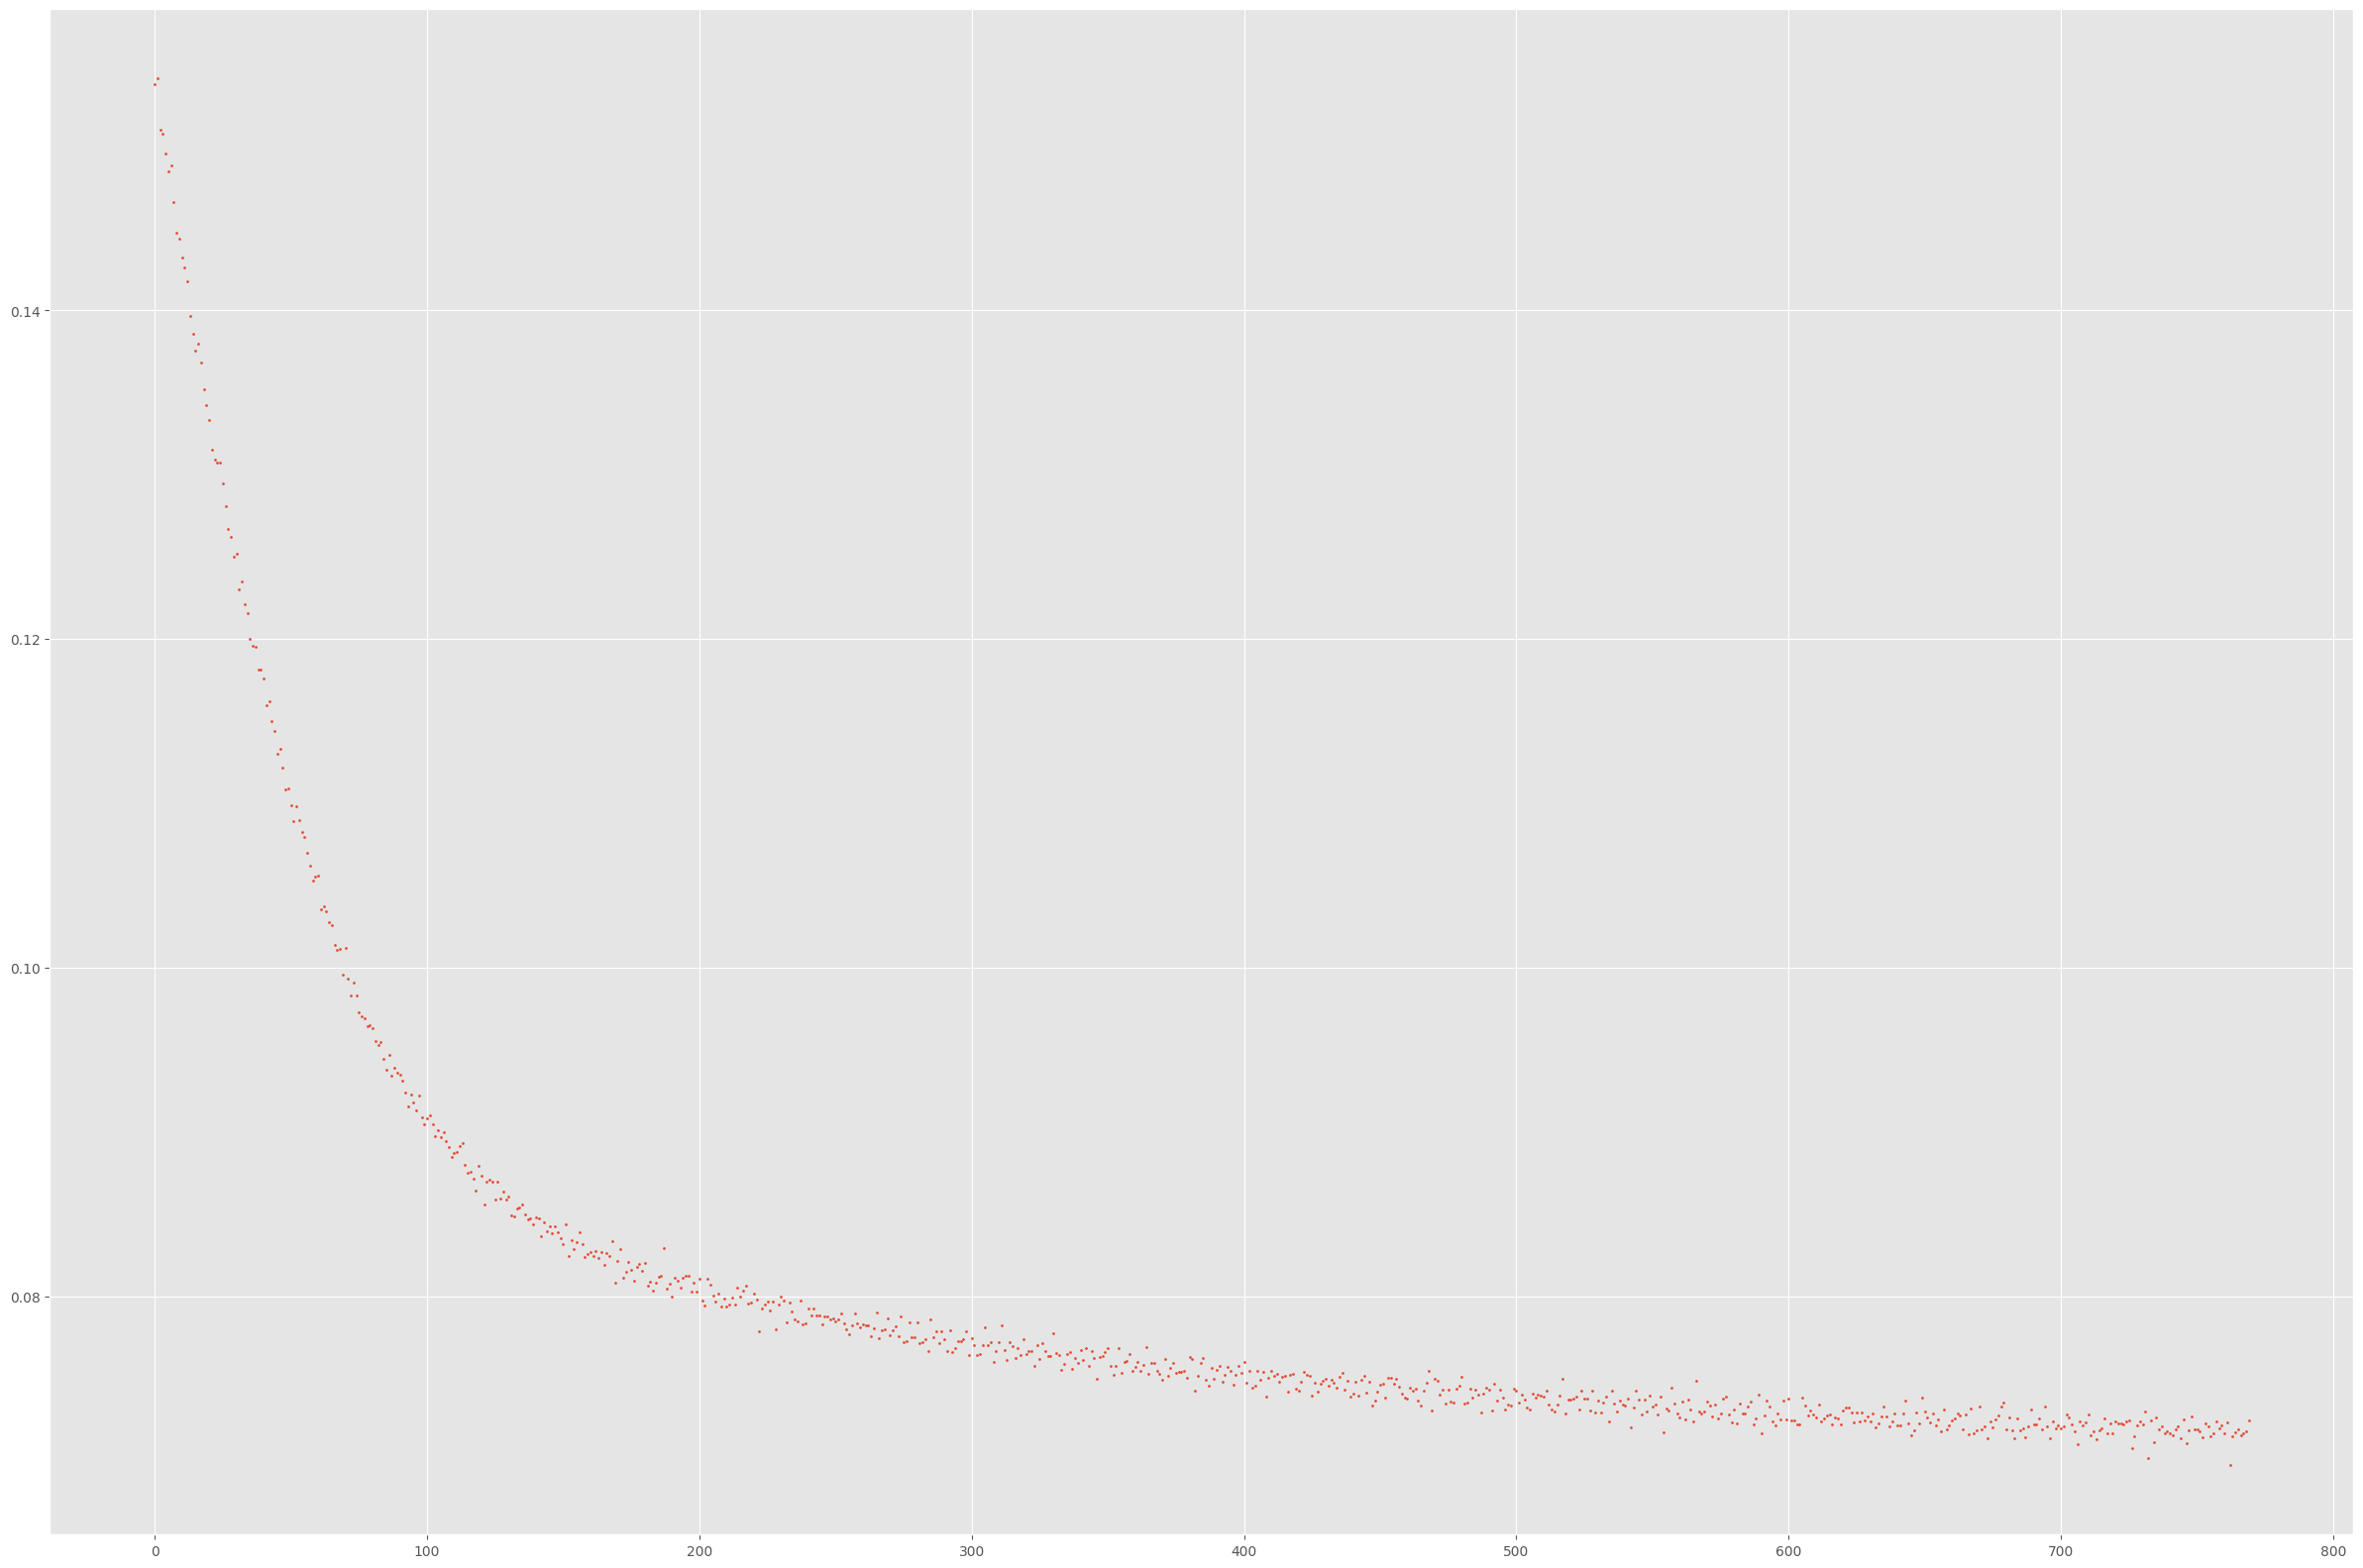

In [ ]:
plt.figure(figsize=(30,20))
plt.scatter(np.arange(len(batch_losses)), batch_losses, s=2)

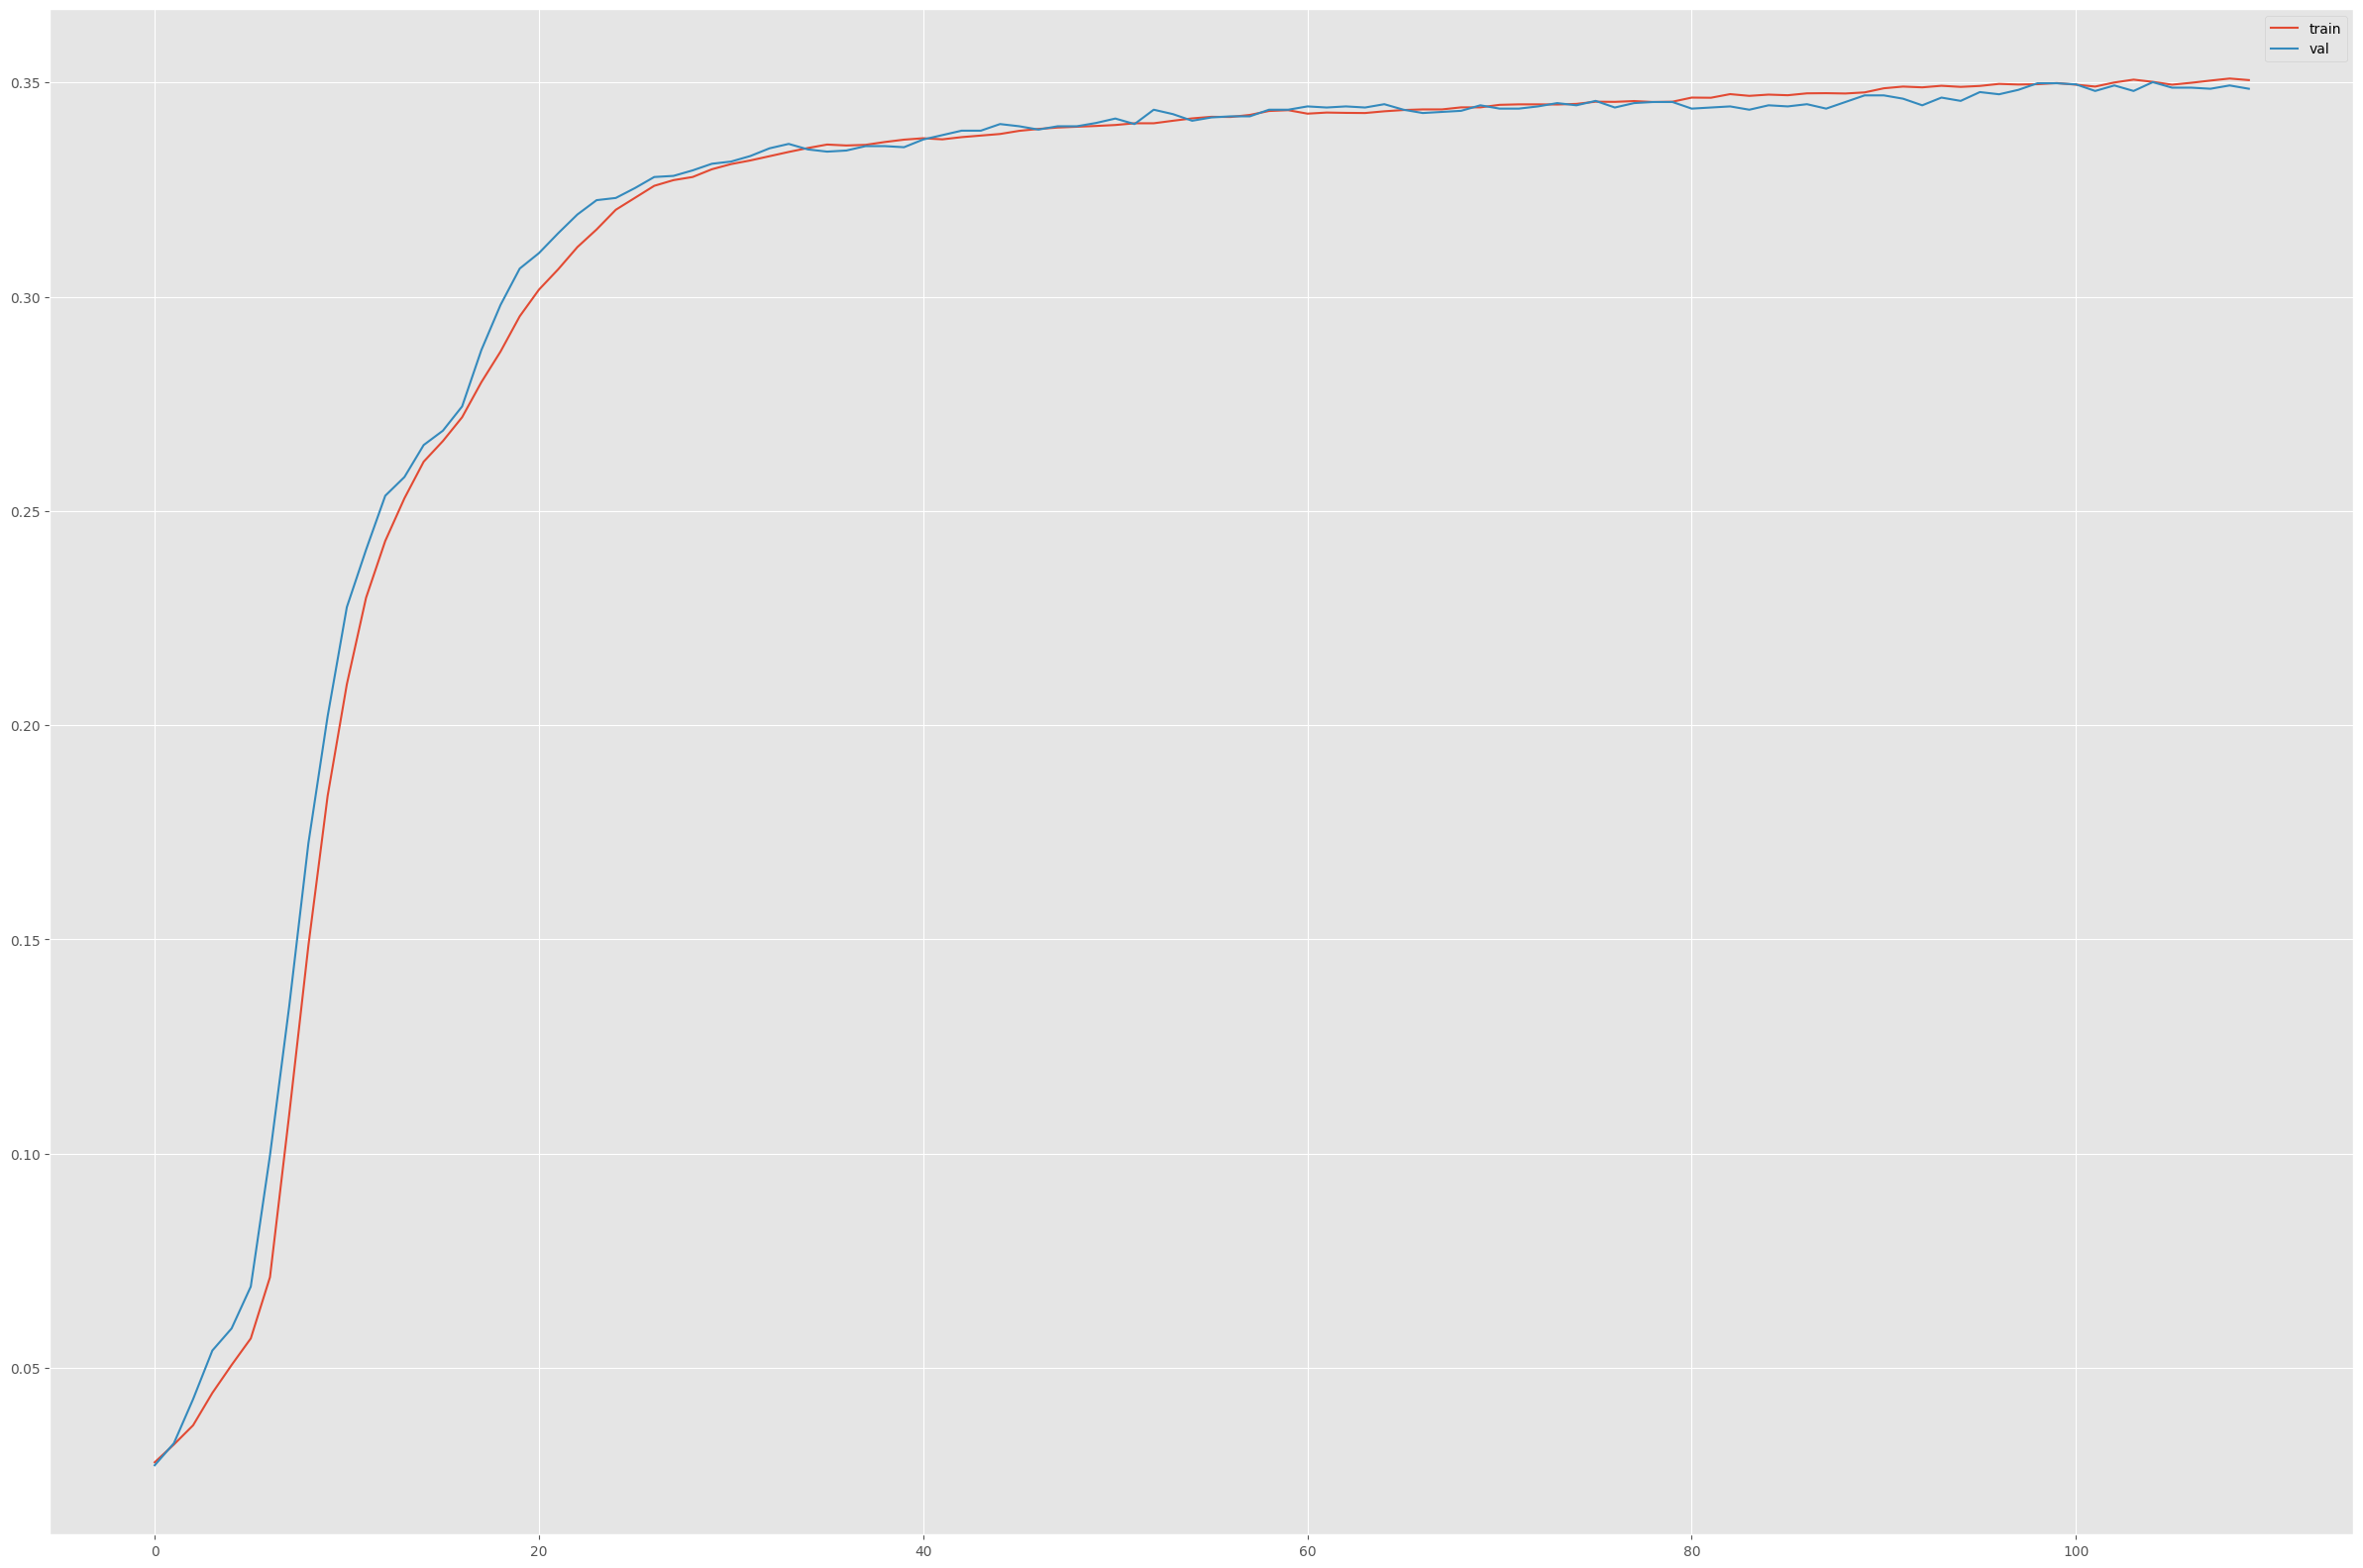

In [ ]:
plt.figure(figsize=(30,20))
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.legend()

In [ ]:
# Evaluation
test_correct, test_count = [0, 0, 0, 0], 0
for idx, batch in enumerate(test_dataloader):
  with torch.no_grad():
    sentences, labels = batch
    #sentences = sentences.to(device)
    #labels = labels.to(device)

    pred = model(sentences)
    loss = loss_function(pred, labels)

    for i in range(1,5):
     test_correct[i-1] += top_k_accuracy(pred, labels, i)
    test_count += len(labels)

for i in range(4):
  print(f"top-{i+1}: {test_correct[i] / test_count}")

top-1: 0.3477869274318065
top-2: 0.6006176016469377
top-3: 0.7050952135872363
top-4: 0.7601646937725167


In [ ]:
test_new_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
pd.read_csv("/content/drive/MyDrive/472 Project Files/Classifications/BioBertClassified.csv")

,Unnamed: 0.1,Unnamed: 0,text,label,raw_outputs,predictions
0,0,42240,"Next, ________ tube was used to obtain Gram st...",38,[-1.72460938 -2.8515625 -2.37890625 -0.749023...,38
1,1,143961,The child was continued on IV fluid and narcot...,10,[-0.08898926 -3.79296875 -1.78808594 2.535156...,29
2,2,17010,"GROSS FINDINGS: ,This 53-year-old Caucasian f...",38,[-2.02734375 -3.04882812 -1.69335938 -0.369628...,38
3,3,105375,The rest showed full strength,22,[-3.13476562 -3.24023438 -3.3671875 0.432373...,22
4,4,76401,She denies any pain elsewhere,27,[-1.34179688 -3.79296875 -1.35449219 1.021484...,5
...,...,...,...,...,...,...
38850,38850,100581,"EXAM: ,BP150/79, HR77, RR22, 37.4C",22,[-3.48828125 -2.72070312 -3.70703125 1.374023...,22
38851,38851,79345,"However, it is our contention that this patien...",27,[-2.86132812 -2.875 -2.00976562 -1.159179...,5
38852,38852,36735,The patient had previous diagnosis of carpal t...,38,[-4.37109375 -4.31640625 -3.6015625 0.418212...,27
38853,38853,61286,"They do play well together; however, The patie...",32,[-2.09570312 -3.67578125 -1.62695312 -0.069580...,5


In [ ]:
# Save values into dataframe

df_out = pd.read_csv("/content/drive/MyDrive/472 Project Files/Classifications/BioBertClassified.csv")
df_out = df_out[["text","label"]].iloc[-len(test_set):]
df_out.reset_index()

,index,text,label
0,31083,Joseph Health Services for rehabilitation therapy,10
1,31084,This does show involvement of bone marrow with...,16
2,31085,RECTAL EXAM: The patient has a drained absces...,5
3,31086,No bulging or erythema to indicate infection i...,15
4,31087,"POSTOPERATIVE DIAGNOSIS: , Slit ventricle synd...",23
...,...,...,...
7767,38850,"EXAM: ,BP150/79, HR77, RR22, 37.4C",22
7768,38851,"However, it is our contention that this patien...",27
7769,38852,The patient had previous diagnosis of carpal t...,38
7770,38853,"They do play well together; however, The patie...",32


In [ ]:
outputs = []
actual_value_locations = []

for batch in iter(test_new_dataloader):
  with torch.no_grad():
    sentence, label = batch
    #print(sentence.shape)
    pred = model(sentence).numpy()
    #print(pred.shape)
    #apply(torch.item, axis=1)
    outputs.append(pred)
    label_num = np.argmax(label).item()
    
    # calculate how high in categorization the correct value is
    sort_idxs = np.argsort(pred)
    #print(sort_idxs.shape)
    idx_loc = np.where(sort_idxs.reshape(40) == label_num)[0].item()
    actual_value_locations.append(40 - idx_loc)
    
    
#actual_value_locations

In [ ]:
display()

In [ ]:
df_out["output"] = outputs
df_out["correct_top_k"] = actual_value_locations 

In [ ]:
df_out["output"]

31083    [[0.0020136065, 0.0005386077, 0.0026071016, 0....
31084    [[0.00341338, 0.0014057538, 0.003000353, 0.047...
31085    [[0.00823524, 0.009593011, 0.004050668, 0.0147...
31086    [[0.0069293655, 0.015756866, 0.003594143, 0.02...
31087    [[5.051086e-05, 0.0004707028, 0.00013900739, 0...
                               ...                        
38850    [[4.0661354e-05, 0.0005043157, 8.400181e-05, 0...
38851    [[0.0009664707, 0.0012949253, 0.00072236254, 0...
38852    [[4.8324255e-05, 0.00016456378, 0.00020492623,...
38853    [[0.0023108993, 0.0006845114, 0.002219024, 0.0...
38854    [[0.00218146, 0.00036484736, 0.0015479218, 0.1...
Name: output, Length: 7772, dtype: object

In [ ]:
df_out.to_csv(base_folder + "ensemble_eval.csv")

---

In [ ]:
outputs

In [ ]:
plt.plt(df_out["output"], 